In [1]:
import os
import glob
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import trimesh
import requests
import zipfile
from io import BytesIO

torch.manual_seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

c:\Users\hydon\anaconda3\envs\pointnet_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


# Get Data and Visualization

In [7]:
data_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
DATA_DIR = data_root + "/data_sets/ModelNet10/ModelNet10/" 
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0005.off"))
mesh.show()

c:\Users\hydon\Documents\Python Scripts\CV_Projects\deep-learning-for-image-process/data_sets/ModelNet10/ModelNet10/


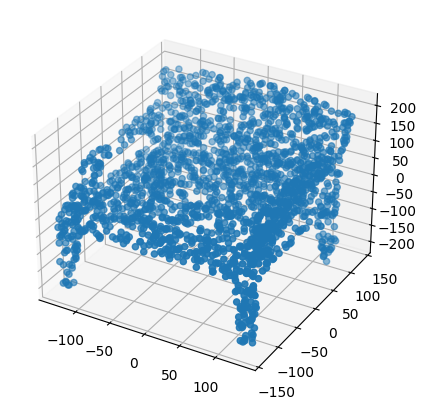

In [8]:
# Sample 2048 points from an image
points = mesh.sample(2048) # (2048, 3)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
# ax.set_axis_off()
plt.show()

# Data Preprocessing

## Generate train and test test by `trimesh.load`

In [26]:
def parse_dataset(num_points=2048):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {} 

    folders = glob.glob(os.path.join(DATA_DIR, "[!REA]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]

        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

10
processing class: bathtub, 0
processing class: bed, 1
processing class: chair, 2
processing class: desk, 3
processing class: dresser, 4
processing class: monitor, 5
processing class: night_stand, 6
processing class: sofa, 7
processing class: table, 8
processing class: toilet, 9


In [27]:
train_points.shape, test_points.shape, train_labels.shape

((3991, 2048, 3), (908, 2048, 3), (3991,))

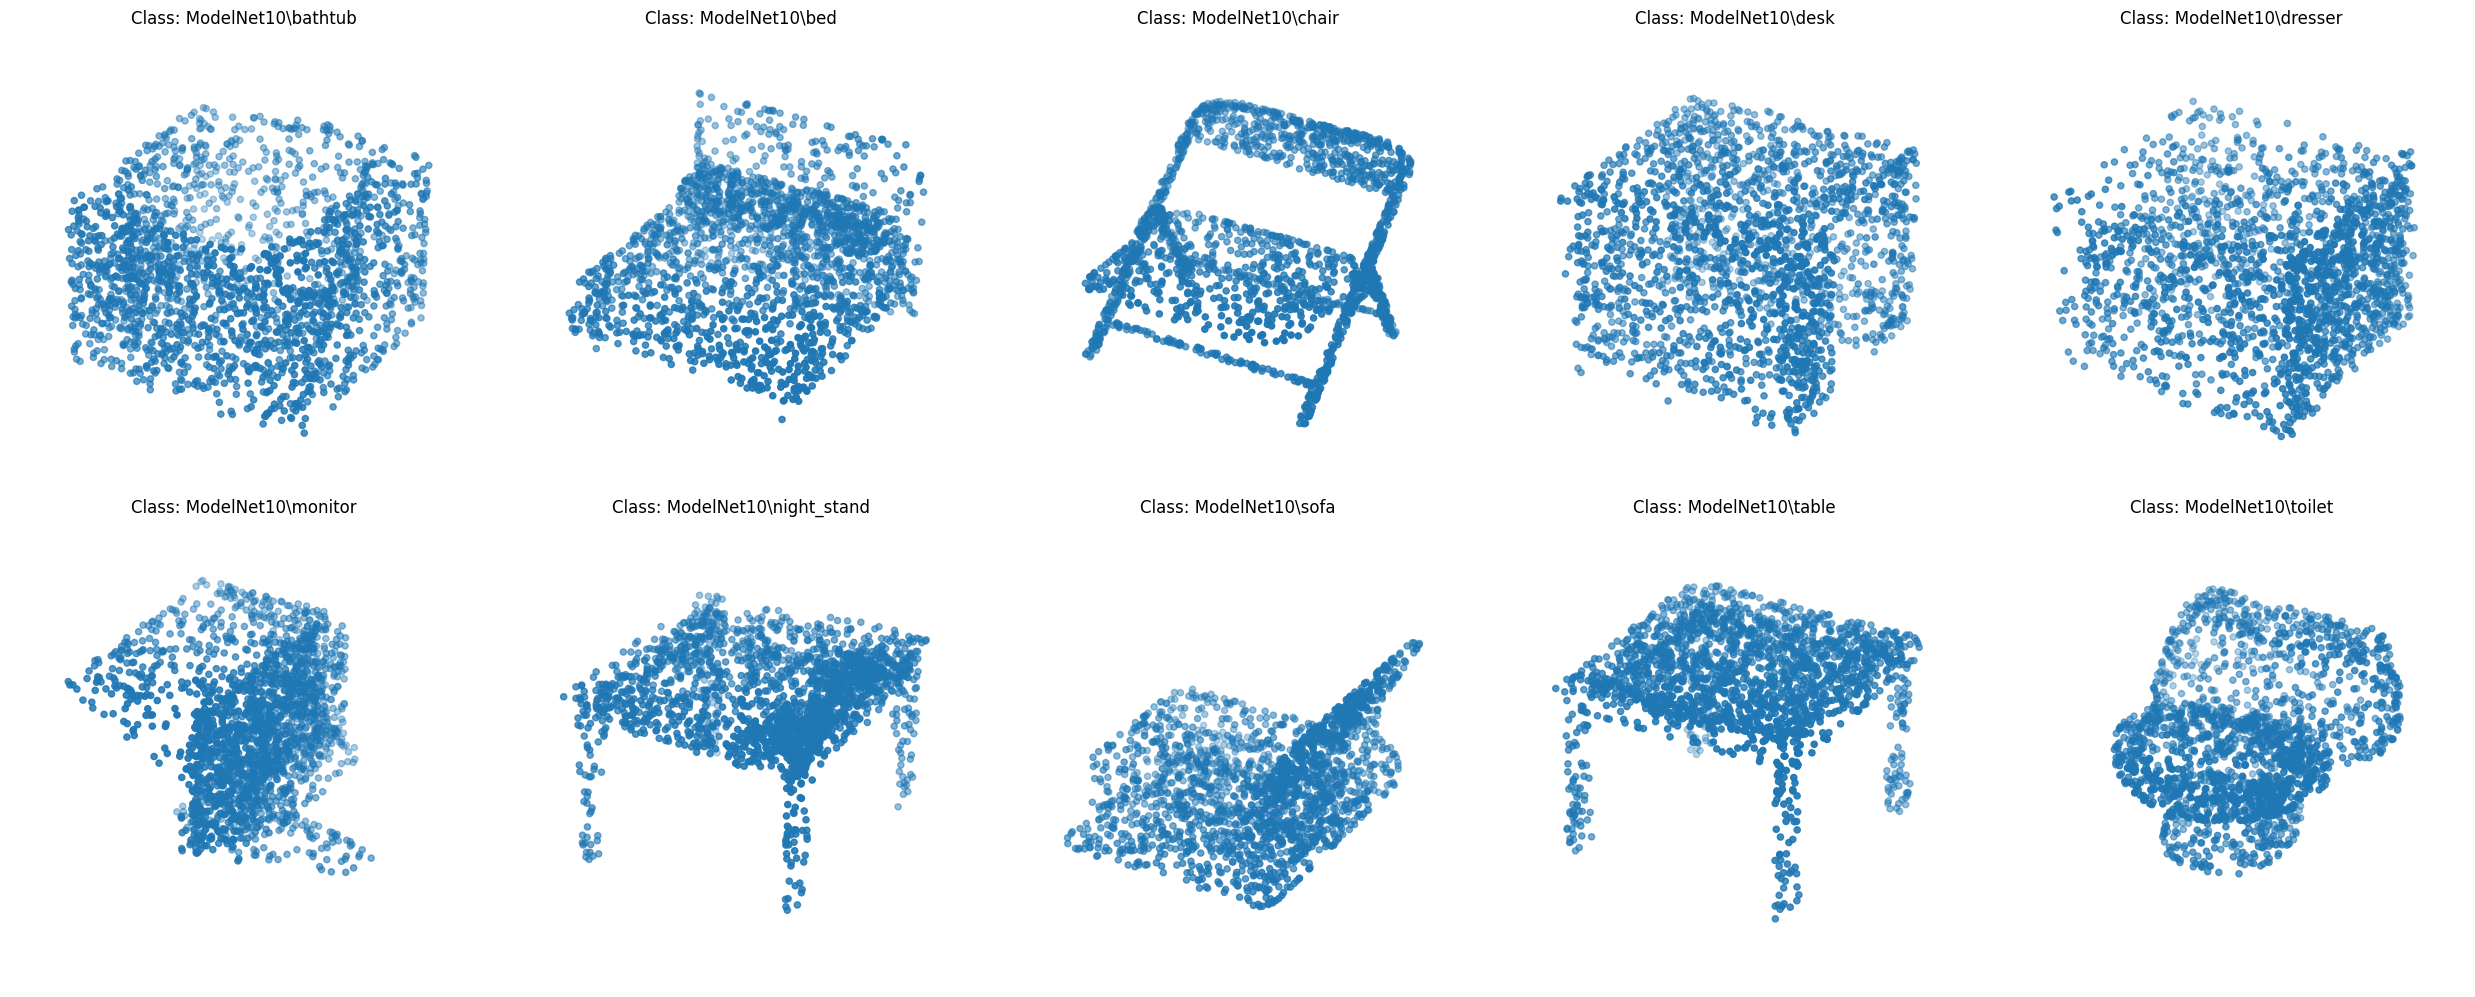

In [28]:
fig = plt.figure(figsize=(25, 10)) 
for label in range(NUM_CLASSES):
    idx = np.where(train_labels == label)[0][0] 
    
    sample_points = train_points[idx]

    ax = fig.add_subplot(2, 5, label + 1, projection='3d')  
    ax.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2])
    ax.set_title(f'Class: {CLASS_MAP[label]}')
    ax.set_axis_off()  

plt.tight_layout()
plt.show()

## Dataset and Dataloader

In [30]:
class PointCloudDataset(Dataset):
    def __init__(self, points, labels):
        # points: N x num_points x 3 
        # labels: N, N is sample number
        self.points = points
        self.labels = labels

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        current_points = self.points[idx]
        current_label = self.labels[idx]
        
        current_points = current_points.transpose(1, 0) #  (channels, num_points) 
        current_points = torch.from_numpy(current_points).float()
        current_label = torch.tensor(current_label, dtype=torch.long)
        
        return current_points, current_label

train_dataset = PointCloudDataset(train_points, train_labels)
test_dataset = PointCloudDataset(test_points, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model: PointNet

![img](https://img-blog.csdnimg.cn/f67b4bb3a61242ff90738e892b2d1679.png)

In [31]:
class TNet(nn.Module):
    def __init__(self, k=3):
        super(TNet, self).__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        # initialize to the unit matrix
        self.fc3.bias.data = torch.zeros(k*k)
        self.fc3.weight.data = torch.FloatTensor(k*k, 256).fill_(0)

    def forward(self, x):
        batch_size = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=False)[0]

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))

        # the output of T-Net last layer is a transformed maxtrix, its size is (k*k)
        x = self.fc3(x).view(batch_size, self.k, self.k)
        
        # Insert a unit matrix to ensure the robust of network
        init_identity = torch.eye(self.k).view(1, self.k, self.k).repeat(batch_size, 1, 1)
        if x.is_cuda:
            init_identity = init_identity.cuda()
        x = x + init_identity
        return x

class PointNet(nn.Module):
    def __init__(self, num_classes=10):
        super(PointNet, self).__init__()
        self.input_transform = TNet(k=3)
        self.feature_transform = TNet(k=64)
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batch_size = x.size(0)

        # Input transform
        trans = self.input_transform(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans)
        x = x.transpose(2, 1)
        x = F.relu(self.bn1(self.conv1(x)))

        # Feature transform
        trans_feat = self.feature_transform(x)
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans_feat)
        x = x.transpose(2, 1)
        x = F.relu(self.bn2(self.conv2(x)))

        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=False)[0]

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(self.dropout(x))))

        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

pointnet = PointNet(num_classes=NUM_CLASSES)
pointnet.to(device)

PointNet(
  (input_transform): TNet(
    (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=9, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (feature_transform): TNet(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 128, kernel_size

# Train

In [32]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()  
    total_loss = 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device) 
        optimizer.zero_grad()  
        outputs = model(data)  
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step()  
        total_loss += loss.item()  

    average_loss = total_loss / len(train_loader)
    return average_loss


def evaluate(model, test_loader, device):
    model.eval() 
    correct = 0
    total = 0

    with torch.no_grad():  
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device) 
            outputs = model(data) 
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() 

    accuracy = correct / total
    return accuracy


criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001) 

epochs = 50  
train_losses = []
test_accuracies = []


for epoch in range(epochs):
    train_loss = train(pointnet, train_loader, optimizer, criterion, device)
    test_accuracy = evaluate(pointnet, test_loader, device)

    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50, Train Loss: 2.0012, Test Accuracy: 0.1123
Epoch 2/50, Train Loss: 1.7422, Test Accuracy: 0.1189
Epoch 3/50, Train Loss: 1.5688, Test Accuracy: 0.1267
Epoch 4/50, Train Loss: 1.4733, Test Accuracy: 0.1156
Epoch 5/50, Train Loss: 1.3882, Test Accuracy: 0.1410
Epoch 6/50, Train Loss: 1.3452, Test Accuracy: 0.1399
Epoch 7/50, Train Loss: 1.3015, Test Accuracy: 0.1300
Epoch 8/50, Train Loss: 1.2084, Test Accuracy: 0.1322
Epoch 9/50, Train Loss: 1.1140, Test Accuracy: 0.1597
Epoch 10/50, Train Loss: 1.0626, Test Accuracy: 0.1134
Epoch 11/50, Train Loss: 0.9675, Test Accuracy: 0.1542
Epoch 12/50, Train Loss: 0.9932, Test Accuracy: 0.1971
Epoch 13/50, Train Loss: 0.8871, Test Accuracy: 0.1619
Epoch 14/50, Train Loss: 0.8335, Test Accuracy: 0.1586
Epoch 15/50, Train Loss: 0.7987, Test Accuracy: 0.1685
Epoch 16/50, Train Loss: 0.7745, Test Accuracy: 0.1322
Epoch 17/50, Train Loss: 0.8231, Test Accuracy: 0.1355
Epoch 18/50, Train Loss: 0.7391, Test Accuracy: 0.1608
Epoch 19/50, Train 

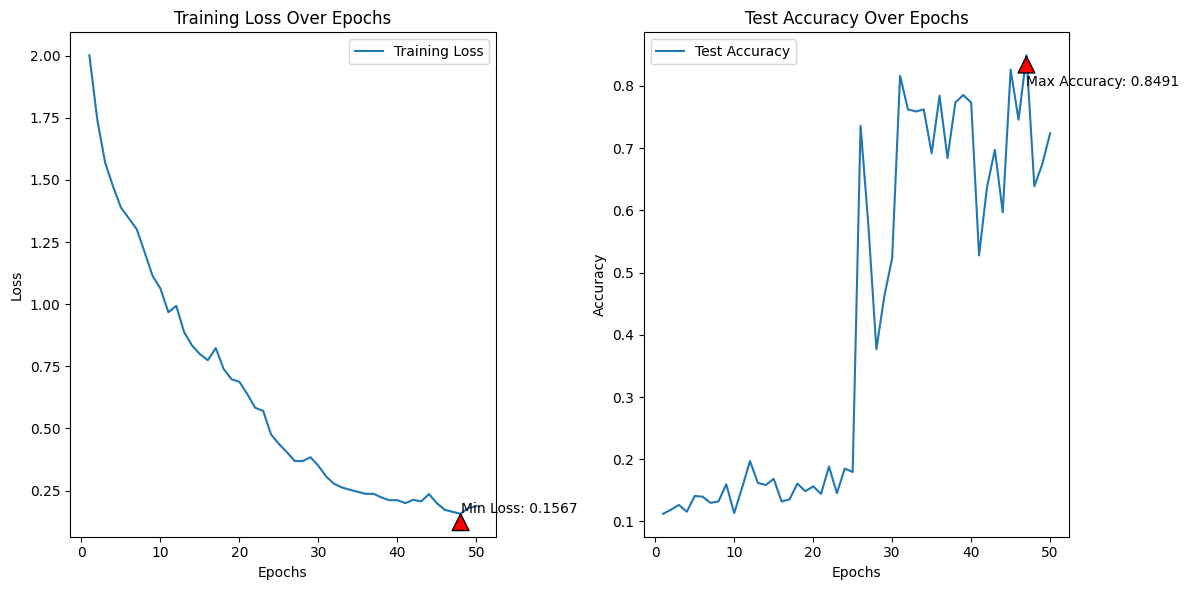

In [33]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 6))

# Plot the training loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# make label on the minimum of training process
min_loss = min(train_losses)
min_loss_epoch = train_losses.index(min_loss) + 1
plt.annotate(f'Min Loss: {min_loss:.4f}',
             xy=(min_loss_epoch, min_loss),
             xytext=(min_loss_epoch, min_loss + 0.005),
             arrowprops=dict(facecolor='red', shrink=0.05))

# plot the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()

# make label on the maximum of validation accuracy
max_accuracy = max(test_accuracies)
max_acc_epoch = test_accuracies.index(max_accuracy) + 1
plt.annotate(f'Max Accuracy: {max_accuracy:.4f}',
             xy=(max_acc_epoch, max_accuracy),
             xytext=(max_acc_epoch, max_accuracy - 0.05),
             arrowprops=dict(facecolor='red', shrink=0.05))

plt.tight_layout()
plt.show()

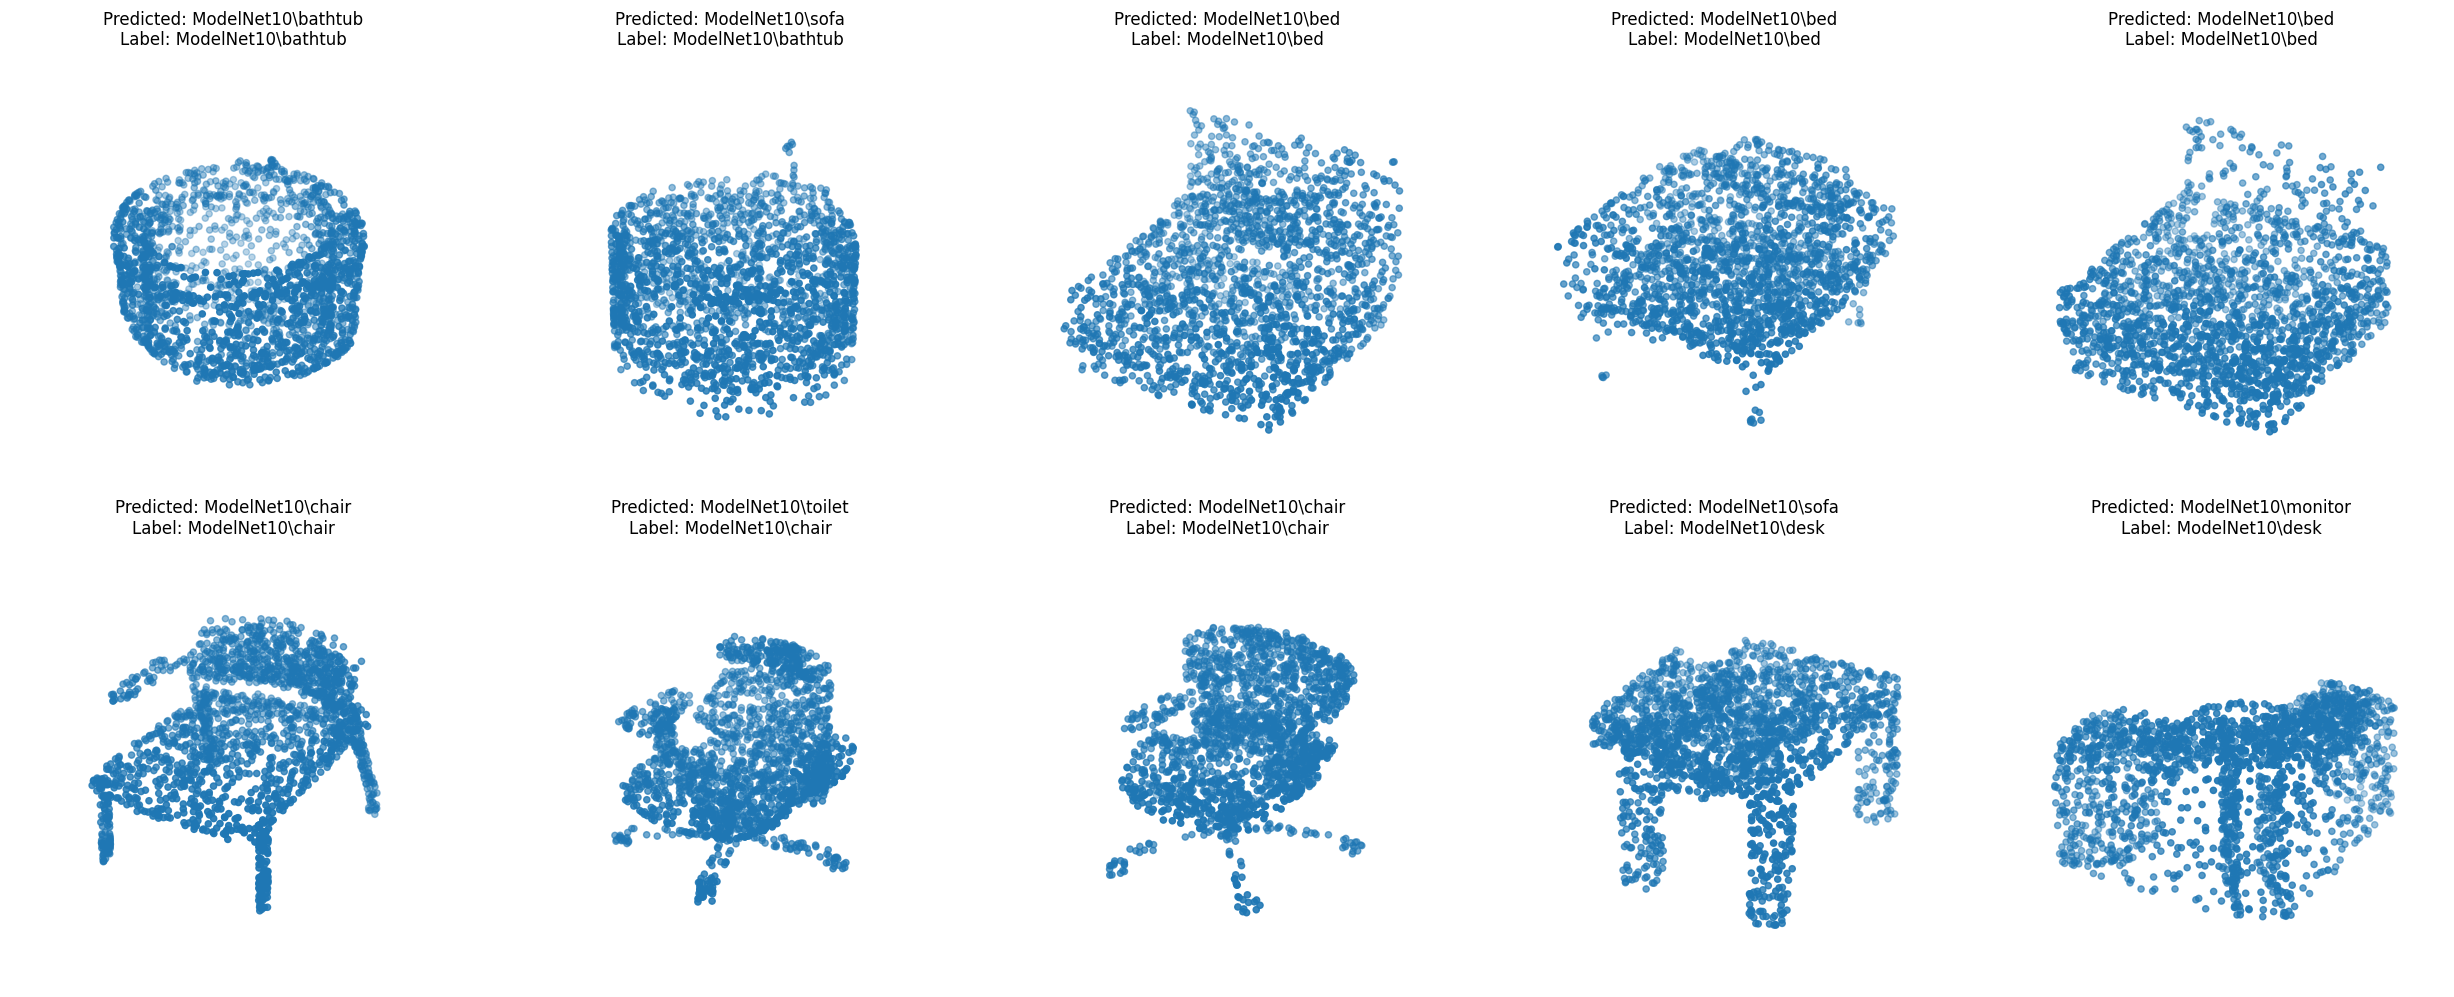

In [34]:
def predict_and_visualize(model, test_loader, class_map, device, num_samples=10, num_cols=5):
    model.eval()  
    num_rows = int(np.ceil(num_samples / num_cols))
    fig = plt.figure(figsize=(25, num_rows * 5))  
    with torch.no_grad(): 
        for i, (data, labels) in enumerate(test_loader):
            if i == num_samples: 
                break
            
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            sample_points = data[0].cpu().numpy().transpose(1, 0) 
            ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
            ax.scatter(sample_points[:, 0], sample_points[:, 1], sample_points[:, 2])
            ax.set_title(f'Predicted: {class_map[predicted[0].item()]}\nLabel: {class_map[labels[0].item()]}')
            ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(pointnet, test_loader, CLASS_MAP, device, num_samples=10, num_cols=5)